In [1]:
import numpy as np
import akantu as aka

In [2]:
import subprocess

ret = subprocess.run("gmsh -3 -order 1 -o cyl_03_mohit.msh cyl_03_mohit.geo", shell=True)
if ret.returncode:
    print("Beware, gmsh could not run: mesh is not regenerated")
else:
    print("Mesh generated")

Mesh generated


In [3]:
material_file = """
material elastic [
    name = steel
    rho = 7800     # density
    E   = 210e6   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""
# writing the material file
open('material.dat', 'w').write(material_file)
#reading the material file
material_file = 'material.dat'


In [4]:
aka.parseInput(material_file)

spatial_dimension = 3
mesh = aka.Mesh(spatial_dimension)
mesh.read('cyl_03_mohit.msh')

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._static)

In [5]:
for dir in [aka._x, aka._y, aka._z]:
    model.applyBC(aka.FixedValue(0.0, dir), "bottom")

# trac = np.eye(3)
trac = [0, 0, 1e8]
model.applyBC(aka.FromTraction(trac), "top")
np.set_printoptions(threshold=10)


In [6]:
steel = model.getMaterial('steel')
steel

In [7]:
solver = model.getNonLinearSolver()
solver.set("max_iterations", 6)
solver.set("threshold", 1e-8)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

model.solveStep()

In [8]:
conn = mesh.getConnectivity(aka._tetrahedron_4)
stress_field = model.getMaterial(0).getStress(aka._tetrahedron_4)

In [9]:
# specify what field to output into paraview files
model.setBaseName("cylinder")
model.addDumpFieldVector("displacement")
model.addDumpFieldVector("external_force")
model.addDumpField("strain")
model.addDumpField("stress")
model.addDumpField("blocked_dofs")

model.dump()

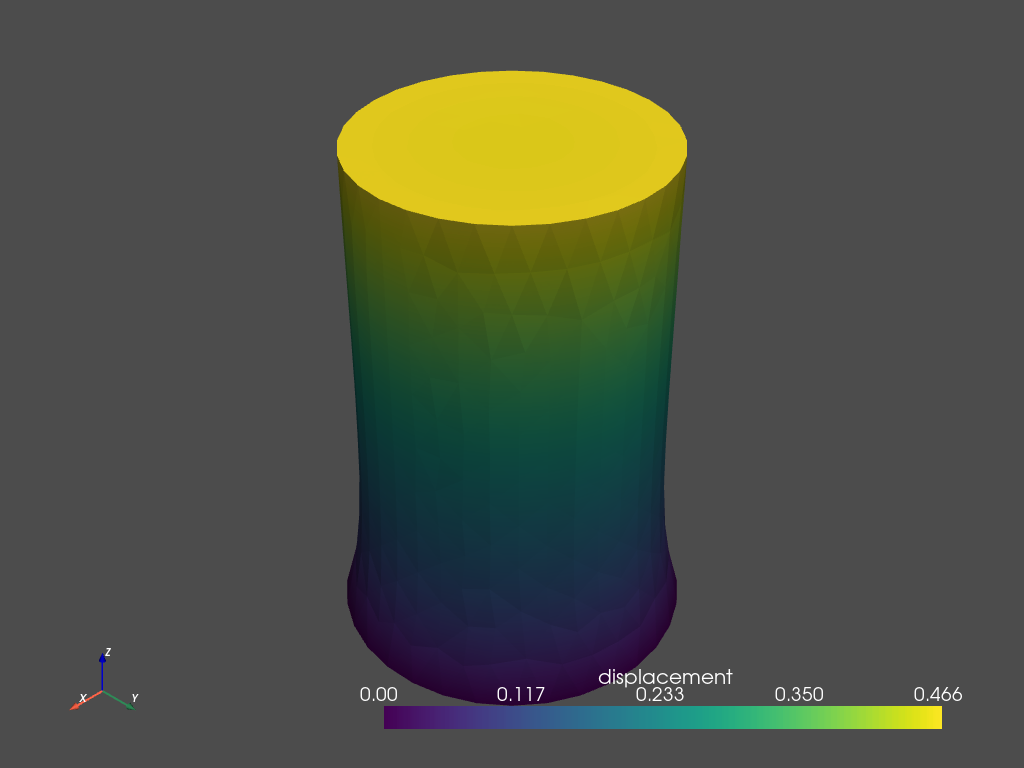

[(2.2676287581466883, 2.2676287581466883, 2.997953502632551),
 (0.0, 0.0, 0.7303247444858627),
 (0.0, 0.0, 1.0)]

In [10]:
import pyvista as pv

p = pv.Plotter(off_screen=False, notebook=False)
p.background_color = 'white'

cyl_msh = pv.read(f'paraview/cylinder_{0:04d}.pvtu')
cyl_msh.set_active_scalars('displacement')
cyl_warped = cyl_msh.warp_by_vector('displacement')
cyl_warped.set_active_scalars('displacement')

cyl_warped.plot()
